# MileStone 1 - Automatic Ticket Classifier



**Importing neccessary libraries**


In [ ]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style
 
import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [ ]:
#importing the training data
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Data and viewing the top 5 and bottom 5 records**

In [ ]:
import os; os.chdir('/content/drive/My Drive/')
data = pd.read_excel('input_data.xlsx')
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 8500 rows and 4 columns. Here are the first five rows of the data...


,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [ ]:
data.tail()

,Short description,Description,Caller,Assignment group
8495,emails not coming in from zz mail,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62
8499,an mehreren pc`s lassen sich verschiedene prgr...,an mehreren pc`s lassen sich verschiedene prgr...,kqvbrspl jyzoklfx,GRP_49


**Checking the columns in Dataset**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [ ]:
# Describe the dataset with various summary and statistics
data.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


**Checking for null values**

In [ ]:
#null value counts in each column
data.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [ ]:
# NULL values are updated with space
data.fillna(str(), inplace=True)
data[pd.isnull(data).any(axis=1)]

,Short description,Description,Caller,Assignment group


**Mojibake Correction**

In [ ]:
!pip install ftfy

     |████████████████████████████████| 71kB 8.8MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.1-cp37-none-any.whl size=41573 sha256=ebf3c913bd8bd0566443259e34c02ea72cf5c91c489becc045b7792fb5d07f1f
  Stored in directory: /root/.cache/pip/wheels/ae/73/c7/9056e14b04919e5c262fe80b54133b1a88d73683d05d7ac65c
Successfully built ftfy


In [ ]:
from ftfy import fix_encoding, fix_text, badness
# detect Mojibakes
def mojibake_present(text):
    if not badness.sequence_weirdness(text):
        return True
    try:
        text.encode('sloppy-windows-1252')
    except UnicodeEncodeError:
        return True
    else:
        return False
    
# Check the dataset for mojibake impact
data[~data.iloc[:,:-1].applymap(mojibake_present).all(1)]

,Short description,Description,Caller,Assignment group
99,password expiry tomorrow,\n\nreceived from: ecprjbod.litmjwsy@gmail.com...,ecprjbod litmjwsy,GRP_0
116,server issues,\r\n\r\nreceived from: bgqpotek.cuxakvml@gmail...,bgqpotek cuxakvml,GRP_0
124,mobile device activation,"from: tvcdfqgp nrbcqwgj \nsent: friday, octobe...",tvcdfqgp nrbcqwgj,GRP_0
162,access to bex,\r\n\r\nreceived from: yfqoaepn.xnezhsit@gmail...,yfqoaepn xnezhsit,GRP_0
164,æ’¤å›ž: ticket_no1564867 -- comments added,\n\nreceived from: abcdri@company.com\n\nwindy...,tycludks cjofwigv,GRP_0
...,...,...,...,...
8470,please review your recent ticketing_tool ticke...,"from: mikhghytr wafglhdrhjop \nsent: thursday,...",azxhejvq fyemlavd,GRP_16
8471,ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥,to å°è´ºï¼Œæ—©ä¸Šç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥,xqyjztnm onfusvlz,GRP_30
8480,customer group enhanced field,\r\n\r\nreceived from: nlearzwi.ukdzstwi@gmail...,nlearzwi ukdzstwi,GRP_9
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


**Language Detection**

In [ ]:
!pip install langdetect

     |████████████████████████████████| 983kB 30.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993223 sha256=ce104af6b111ffff68094fa88aa0623dc4057a3fddfdfc93a6324fa3a93a2ffa
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


In [ ]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(data))):
    # split by space into list, take the first x intex, join with space
    text = data.iloc[ii]['Short description'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
   
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
      
        except Exception as e:
            
            try:
      
                lang = detect(data.iloc[ii]['Description'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 8500/8500 [01:23<00:00, 101.39it/s]


In [ ]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 8500

{'af': 500,
 'ca': 129,
 'cs': 8,
 'cy': 24,
 'da': 124,
 'de': 397,
 'en': 5979,
 'es': 95,
 'et': 17,
 'fi': 11,
 'fr': 279,
 'hr': 6,
 'id': 15,
 'it': 266,
 'lt': 8,
 'lv': 7,
 'nl': 146,
 'no': 174,
 'pl': 51,
 'pt': 34,
 'ro': 35,
 'sk': 12,
 'sl': 19,
 'so': 4,
 'sq': 18,
 'sv': 103,
 'sw': 1,
 'tl': 25,
 'tr': 10,
 'vi': 3}


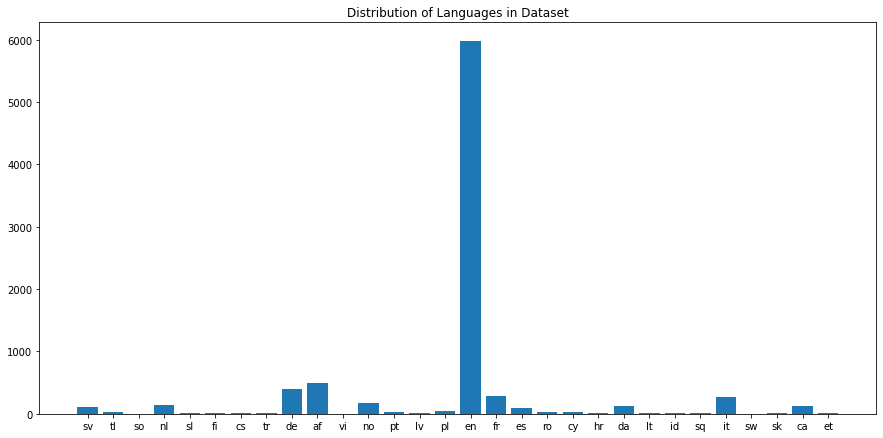

In [ ]:
data['language'] = languages
plt.figure(figsize = (15 , 7.2))
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

4 B] Treating other Data Inconsistencies

Text Preprocessing

Text preprocessing is the process of transferring text from human language to machine-readable format for further processing. After a text was obtained, text normalization was taken into consideration.Text normalization included:

converting all letters to lower or upper case
converting numbers into words or removing numbers
removing punctuations, accent marks and other diacritics
removing white spaces
removing stop words, sparse terms, and particular words

In [ ]:
# Before removing caller email it was observed that there was a similar string  present in description, so that was needed to clean first
data_df = data.copy()
data_df['Caller email'] = data_df.apply(lambda x: x['Caller'].replace(' ', '.'), axis=1)
data_df['Caller email'] = data_df.apply(lambda x: x['Caller email'] + '@gmail.com', axis=1)
data_df.head(10)

,Short description,Description,Caller,Assignment group,language,Caller email
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,spxjnwir.pjlcoqds@gmail.com
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,af,hmjdrvpb.komuaywn@gmail.com
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,en,eylqgodm.ybqkwiam@gmail.com
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,xbkucsvz.gcpydteq@gmail.com
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no,owlgqjme.qhcozdfx@gmail.com
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,en,eflahbxn.ltdgrvkz@gmail.com
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,en,jyoqwxhz.clhxsoqy@gmail.com
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,en,eqzibjhw.ymebpoih@gmail.com
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,en,mdbegvct.dbvichlg@gmail.com
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,en,fumkcsji.sarmtlhy@gmail.com


In [ ]:
# Replacing Caller email id in Description column by ''
data_df['Description']=data_df.apply(lambda x: x['Description'].replace(x['Caller email'], ''), axis=1)
data_df.head(10)

,Short description,Description,Caller,Assignment group,language,Caller email
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,spxjnwir.pjlcoqds@gmail.com
1,outlook,"\r\n\r\nreceived from: \r\n\r\nhello team,\r\n...",hmjdrvpb komuaywn,GRP_0,af,hmjdrvpb.komuaywn@gmail.com
2,cant log in to vpn,\r\n\r\nreceived from: \r\n\r\nhi\r\n\r\ni can...,eylqgodm ybqkwiam,GRP_0,en,eylqgodm.ybqkwiam@gmail.com
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,xbkucsvz.gcpydteq@gmail.com
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no,owlgqjme.qhcozdfx@gmail.com
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,en,eflahbxn.ltdgrvkz@gmail.com
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,en,jyoqwxhz.clhxsoqy@gmail.com
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,en,eqzibjhw.ymebpoih@gmail.com
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,en,mdbegvct.dbvichlg@gmail.com
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0,en,fumkcsji.sarmtlhy@gmail.com


In [ ]:
# Dropping Caller email
data_df = data_df.drop(['Caller email'],axis=1)

In [ ]:
#Text Cleanup


#removing spaces trailing
data_df['Short description'] = data_df['Short description'].str.strip()
data_df['Description'] = data_df['Description'].str.strip()

#removing tabs and carriage returns
data_df.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)

#removing digits    
data_df['Description'] = data_df['Description'].replace('\d+', '', regex=True)
data_df['Short description'] = data_df['Short description'].replace('\d+', '', regex=True)
    
#removing more than 1 space
data_df.replace('\s+', ' ', regex=True, inplace=True)

#making lower case
data_df.apply(lambda x: x.astype(str).str.lower())

,Short description,Description,Caller,Assignment group,language
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,grp_0,en
1,outlook,"received from: hello team, my meetings/skype m...",hmjdrvpb komuaywn,grp_0,af
2,cant log in to vpn,received from: hi i cannot log on to vpn best,eylqgodm ybqkwiam,grp_0,en
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,grp_0,en
4,skype error,skype error,owlgqjme qhcozdfx,grp_0,no
...,...,...,...,...,...
8495,emails not coming in from zz mail,"received from: good afternoon, i am not receiv...",avglmrts vhqmtiua,grp_29,en
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,grp_0,en
8497,vip: windows password reset for tifpdchb pedxruyf,vip: windows password reset for tifpdchb pedxruyf,oybwdsgx oxyhwrfz,grp_0,en
8498,machine nã£o estã¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,grp_62,es


In [ ]:
data_df_clean = data_df.copy()
# Removing Spl Chars
spec_chars = ["#","%","&","*","+",",","<",
              "=",">","@","\\","^","_",
              "`","{","|","}","~",":",".","/","?","(",")","-","[","]",";","::","//","$","!"]

for char in spec_chars:
    data_df_clean['Short description'] = data_df_clean['Short description'].str.replace(char, ' ')
    data_df_clean['Description'] = data_df_clean['Description'].str.replace(char, ' ')
data_df_clean.head(10)

,Short description,Description,Caller,Assignment group,language
0,login issue,verified user details employee manager na...,spxjnwir pjlcoqds,GRP_0,en
1,outlook,received from hello team my meetings skype m...,hmjdrvpb komuaywn,GRP_0,af
2,cant log in to vpn,received from hi i cannot log on to vpn best,eylqgodm ybqkwiam,GRP_0,en
3,unable to access hr tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0,en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0,en
6,event critical HostName company com the valu...,event critical HostName company com the valu...,jyoqwxhz clhxsoqy,GRP_1,en
7,ticket no employment status new non employe...,ticket no employment status new non employe...,eqzibjhw ymebpoih,GRP_0,en
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0,en
9,ticket update on inplant,ticket update on inplant,fumkcsji sarmtlhy,GRP_0,en


In [ ]:
#removing more than 1 space
data_df_clean.replace('\s+', ' ', regex=True, inplace=True)

Comments:

Entire dataset was converted into lower case
Users email addresses would add NO value to our analysis, despite the fact that user id was given in the caller column. So all email adresses were removed from the dataset
All numerals were removed because they were dominating the dataset if we were to convert them into their word representation otherwise.
All punctuation marks were removed which would have been a hindrance in lemmatization.
All occurances of more than one blank spaces, horizontal tab spaces, new line breaks etc. were replaced with single blank space.

**4 C]Translating Text from other languages to English:**

4 C] Stemming and Lemmatization

Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing. In grammar, inflection is known as the modification of a word to express different grammatical categories such as tense, case, voice, aspect, person, number, gender, and mood. An inflection expresses one or more grammatical categories with a prefix, suffix or infix, or another internal modification such as a vowel change.

Stemming

Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

Lemmatization

Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

spaCy

The spaCy library is one of the most popular NLP libraries along with NLTK which contains only one, but the best algorithm to solve any Natural Language problem. Once it is downloaded and installed, the next step is to download the language model, which is used to perform a variety of NLP tasks.

Installation:

using pypi: !pip install spacy using conda: conda install -c conda-forge spacy

In [ ]:
#!pip install spacy
import spacy
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
spacy.load('en_core_web_lg')
import en_core_web_sm

In [ ]:
# Initialize spacy 'en' medium model, keeping only tagger component needed for lemmatization
#nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
nlp = en_core_web_sm.load()
# Define a function to lemmatize the descriptions
def lemmatizer(sentence):
    # Parse the sentence using the loaded 'en' model object `nlp`
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc if token.lemma_ !='-PRON-'])

In [ ]:
# Take an example of row# 43 Description and lemmatize it
print('\033[1mOriginal text:\033[0m')
print(data_df_clean['Description'][43])
print('_'*100)
print('\033[1mLemmatized text:\033[0m')
print(lemmatizer(data_df_clean['Description'][43]))

Original text:
received from hi the printer printer is not working and needs a part replaced can you reroute the jobs in queue to printer printer wihuyjdo qpogfwkb has indicated that prqos needs a new part and it may not deliver for a few days so the inwarehouse tools will need to print on printer for now this needs to be taken care of today since the inwarehouse tools are printed and are picked up by an outside vendor at pm in usa on a daily basis please contact dkmcfreg anwmfvlgenkataramdntyana if you have questions about the jobs in queue for today 
____________________________________________________________________________________________________
Lemmatized text:
receive from hi the printer printer be not work and need a part replace can reroute the job in queue to printer printer wihuyjdo qpogfwkb have indicate that prqos need a new part and may not deliver for a few day so the inwarehouse tool will need to print on printer for now this need to be take care of today since the inw

In [ ]:
# Apply the Lemmatization to entire dataset
data_df_clean['Description'] = data_df_clean['Description'].apply(lemmatizer)
data_df_clean['Short description'] = data_df_clean['Short description'].apply(lemmatizer)

# Verify the data
data_df_clean.tail()

,Short description,Description,Caller,Assignment group,language
8495,email not come in from zz mail,receive from good afternoon i be not receive t...,avglmrts vhqmtiua,GRP_29,en
8496,telephony software issue,telephony software issue,rbozivdq gmlhrtvp,GRP_0,en
8497,vip windows password reset for tifpdchb pedxruyf,vip windows password reset for tifpdchb pedxruyf,oybwdsgx oxyhwrfz,GRP_0,en
8498,machine nÃ£o estÃ ¡ funcionando,i be unable to access the machine utility to f...,ufawcgob aowhxjky,GRP_62,es
8499,an mehreren pc s lassen sich verschiedene prgr...,an mehreren pc s lassen sich verschiedene prgr...,kqvbrspl jyzoklfx,GRP_49,de


EDA(Exploratory Data Analysis):
EDA is a method of analysing, visualizing, summarizing and interpreting the information that is hidden in the dataset.


In [ ]:
df = data_df_clean.copy()
# Create new features of length and word count for both the Short description and Description Columns
df.insert(1, 'sd_len', df['Short description'].astype(str).apply(len))
df.insert(2, 'sd_word_count', df['Short description'].apply(lambda x: len(str(x).split())))
df.insert(4, 'desc_len', df['Description'].astype(str).apply(len))
df.insert(5, 'desc_word_count', df['Description'].apply(lambda x: len(str(x).split())))
df.head()

,Short description,sd_len,sd_word_count,Description,desc_len,desc_word_count,Caller,Assignment group,language
0,login issue,11,2,verified user detail employee manager name c...,179,32,spxjnwir pjlcoqds,GRP_0,en
1,outlook,7,1,receive from hello team meeting skype meeting ...,135,23,hmjdrvpb komuaywn,GRP_0,af
2,can not log in to vpn,21,6,receive from hi i can not log on to vpn best,44,11,eylqgodm ybqkwiam,GRP_0,en
3,unable to access hr tool page,29,6,unable to access hr tool page,29,6,xbkucsvz gcpydteq,GRP_0,en
4,skype error,11,2,skype error,11,2,owlgqjme qhcozdfx,GRP_0,no


In [ ]:
# let see the number of classes in Assignment group
df['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

The Assignment group contains 74 different classes.

In [ ]:
df_inc = df['Assignment group'].value_counts().reset_index()
df_inc['percentage'] = (df_inc['Assignment group']/df_inc['Assignment group'].sum())*100
df_inc.head()


,index,Assignment group,percentage
0,GRP_0,3976,46.776471
1,GRP_8,661,7.776471
2,GRP_24,289,3.400000
3,GRP_12,257,3.023529
4,GRP_9,252,2.964706


Text(0.5, 1.0, 'Tickets Distribution')

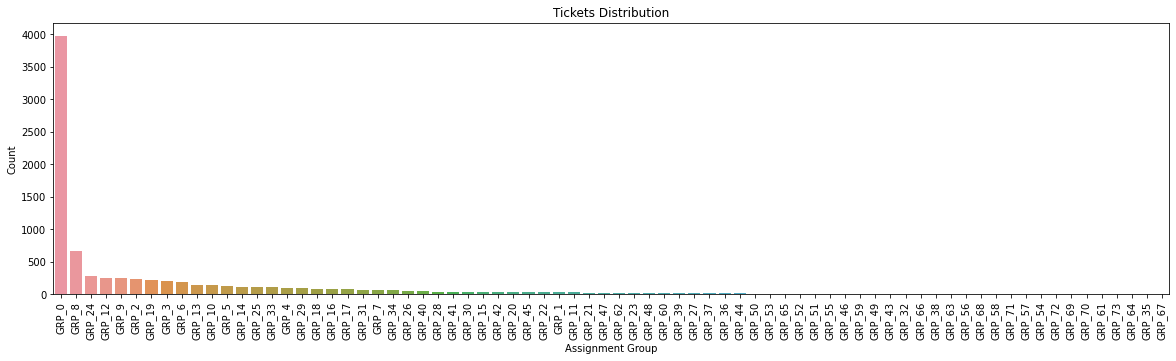

In [ ]:
# Assignment Group distribution
import seaborn as sns
plt.subplots(figsize = (20,5))

sns.countplot(x='Assignment group', data=df,order = df['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('Tickets Distribution')

From the above plot we analyse that almost 47% of the tickets assigned to GRP_0.The second highest assignment group is GRP_8 which is 7.78% of the total dataset.
As assignment group attribue is the target column in our dataset, these tickets distribution shows the dataset is miserably imbalanced.

Text(0.5, 1.0, 'Tickets Distribution without GRP_0')

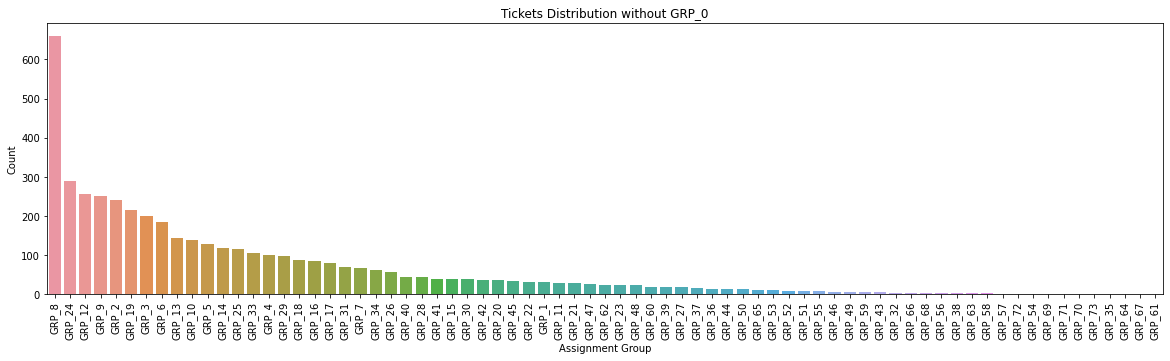

In [ ]:
#Distribution of only records that donot belong to GRP_0
df1 = df[df["Assignment group"]!= 'GRP_0']
plt.subplots(figsize=(20,5))
sns.countplot(x='Assignment group', data=df1,order = df1['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('Tickets Distribution without GRP_0')

In [ ]:
#Distribution of callers
# Top 5 callers in each assignment group
top_n = 5
s = df['Caller'].groupby(df['Assignment group']).value_counts()
caller_grp = pd.DataFrame(s.groupby(level=0).nlargest(top_n).reset_index(level=0, drop=True))
caller_grp.head(15)

Caller
Assignment group Caller                   
GRP_0            fumkcsji sarmtlhy     132
                 rbozivdq gmlhrtvp      86
                 olckhmvx pcqobjnd      54
                 efbwiadp dicafxhv      45
                 mfeyouli ndobtzpw      13
GRP_1            bpctwhsn kzqsbmtp       6
                 jloygrwh acvztedi       4
                 jyoqwxhz clhxsoqy       3
                 spxqmiry zpwgoqju       3
                 kbnfxpsy gehxzayq       2
GRP_10           bpctwhsn kzqsbmtp      60
                 ihfkwzjd erbxoyqk       6
                 dizquolf hlykecxa       5
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3

In [ ]:
# Check if any caller appears to raise ticket for multiple groups
mul_caller = caller_grp[caller_grp.Caller.duplicated()]
uni_mul_caller = [idx[1] for idx in mul_caller.index[mul_caller.Caller.unique()]]
print(f'\033[1mFollowing {len(uni_mul_caller)} callers happen to raise tickets for multiple groups:\033[0m\n')
print(uni_mul_caller)

mul_caller

Following 15 callers happen to raise tickets for multiple groups:

['hlrmufzx qcdzierm', 'fbgetczn jlsvxura', 'gnasmtvx cwxtsvkm', 'ihfkwzjd erbxoyqk', 'tqfnalpj qyoscnge', 'fmqubnvs kcxpeyiv', 'tghrloks jbgcvlmf', 'jwqyxbzs adpvilqu', 'nuhfwplj ojcwxser', 'oldrctiu bxurpsyi', 'vlymsnej whlqxcst', 'dkmcfreg anwmfvlg', 'bpctwhsn kzqsbmtp', 'spxqmiry zpwgoqju', 'obanjrhg rnafleys']


Caller
Assignment group Caller                   
GRP_1            spxqmiry zpwgoqju       3
GRP_10           ihfkwzjd erbxoyqk       6
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3
GRP_11           tghrloks jbgcvlmf       2
...                                    ...
GRP_73           kcnosyae zlpmfxgs       1
GRP_8            ZkBogxib QsEJzdZO      54
GRP_9            ctzykflo evzbhgru       3
                 sholvcmf bjtpomrl       3
                 urhpnlaf agmsfqil       3

[281 rows x 1 columns]

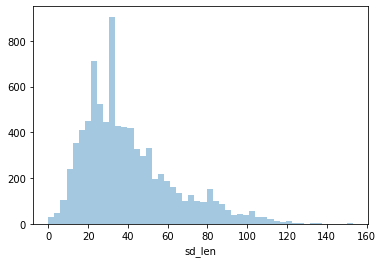

In [ ]:
# Distribution of short description length
sns.distplot(df['sd_len'], kde=False)

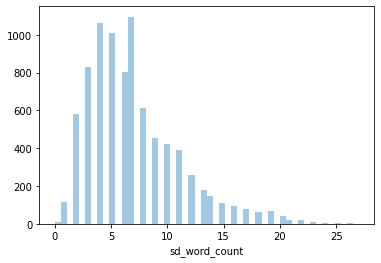

In [ ]:
# Distribution of word count of short description
sns.distplot(df['sd_word_count'], kde=False)

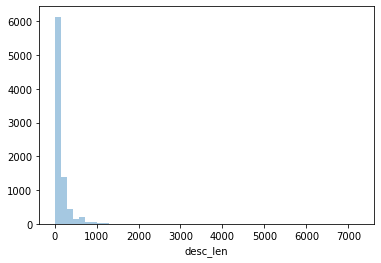

In [ ]:
# Distribution of description length
sns.distplot(df['desc_len'], kde=False)

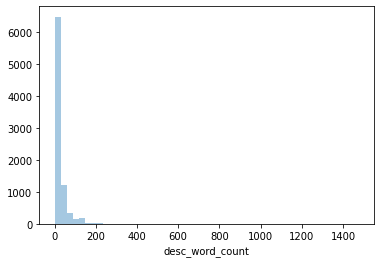

In [ ]:
# Distribution of word count of  description
sns.distplot(df['desc_word_count'], kde=False)

 **N-grams** are used to describe the number of words used as observation points.

Looking at most frequent n-grams can give a better understanding of the context in which the word was used.

To build a representation of our vocabulary we will use Countvectorizer. Countvectorizer is a simple method used to tokenize, vectorize and represent the corpus in an appropriate form.

comparison of unigrams before and after removing stop words:

to 6598
the 6343
be 6222
in 3454
from 3313
no 2755
not 2582
job 2573
receive 2507
company 2438
and 2394
tool 2076
on 2034
yes 2027
please 1952
na 1939
for 1908
com 1840
have 1774
of 1609


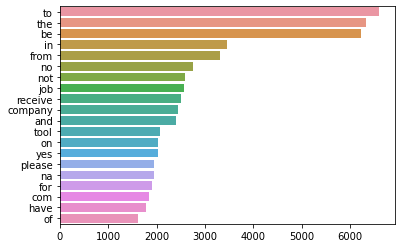

In [ ]:
# distribution of top unigrams before removing stop words
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Description'], 20)

for word, freq in common_words:
    print(word, freq)

x,y=map(list,zip(*common_words))
sns.barplot(x=y,y=x)

job 2573
receive 2507
company 2438
tool 2076
yes 2027
na 1939
com 1840
password 1425
user 1405
erp 1210
sid 1105
monitor 1049
ticket 1024
access 984
issue 971
scheduler 969
fail 952
email 863
reset 849
work 821


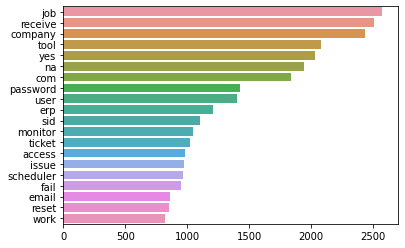

In [ ]:
# distribution of top unigrams after removing stop words

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Description'], 20)

for word, freq in common_words:
    print(word, freq)

x,y=map(list,zip(*common_words))
sns.barplot(x=y,y=x)

Comparison of bigrams before and after removing stop words:

receive from 2256
yes no 1744
no na 1570
company com 1364
monitor tool 970
tool company 970
job scheduler 969
in job 963
from monitor 961
fail in 810
scheduler at 808
com job 785
unable to 776
be not 751
to the 628
can not 485
job job 480
cid image 478
job fail 477
do not 427


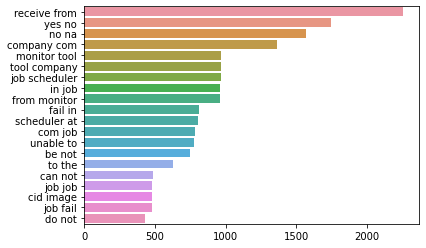

In [ ]:
# distribution of top bigrams before removing stop words

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Description'], 20)

for word, freq in common_words:
    print(word, freq)

x,y=map(list,zip(*common_words))
sns.barplot(x=y,y=x)

yes na 1570
company com 1364
monitor tool 970
tool company 970
job scheduler 969
receive monitor 961
fail job 809
com job 785
job job 634
job fail 482
cid image 478
backup circuit 427
receive hello 357
password reset 354
gmail com 316
erp sid 305
telecom vendor 304
na company 288
type outage 286
na yes 285


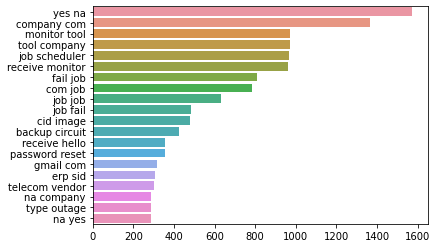

In [ ]:
# distribution of top bigrams after removing stop words

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Description'], 20)

for word, freq in common_words:
    print(word, freq)

x,y=map(list,zip(*common_words))
sns.barplot(x=y,y=x)

**Wordcloud** is a great way to represent text data. The size and color of each word that appears in the wordcloud indicate it’s frequency or importance.

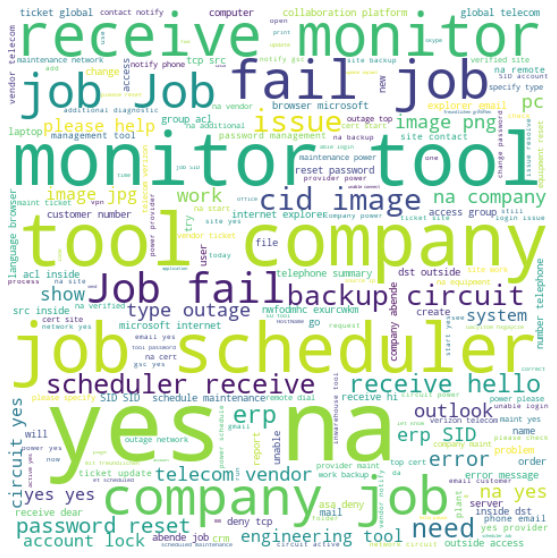

In [ ]:
# word cloud for description
from wordcloud import WordCloud

wordclouds=' '.join(map(str, df['Description'])) 

wordcloud = WordCloud(width=480, height=480, background_color="white").generate(wordclouds)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


In the description the words occured frequently are job, scheduler, company, monitor, tool, receive, fail, backup, circuit.


Common issue here are related to Job Scheduler, System & Hardware and network.

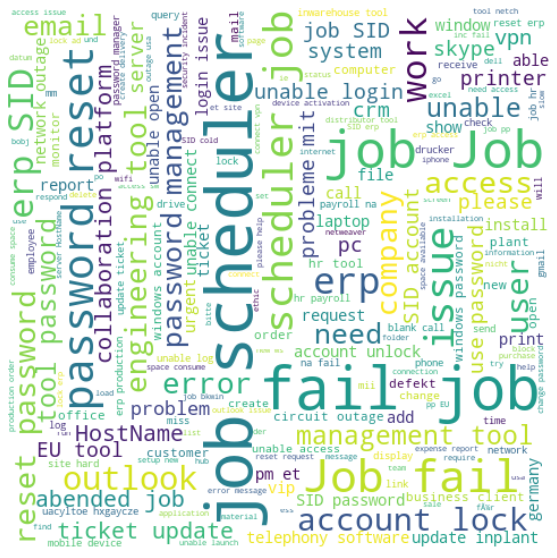

In [ ]:
# word cloud for short description

wordclouds=' '.join(map(str, df['Short description'])) 

wordcloud = WordCloud(width=480, height=480, background_color="white").generate(wordclouds)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


In the short description the words occured frequently are work, job, scheduler, password, reset.

user account and browser related issues, job scheduler related issues seems to be most common issues here.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from time import time


In [ ]:
# A class that logs the time
class Timer():
    '''
    A generic class to log the time
    '''
    def __init__(self):
        self.start_ts = None
    def start(self):
        self.start_ts = time()
    def stop(self):
        return 'Time taken: %2fs' % (time()-self.start_ts)
    
timer = Timer()

# A method that plots the Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

# A method to train and test the model
def run_classification(estimator, X_train, X_test, y_train, y_test, arch_name=None, pipelineRequired=True, isDeepModel=False):
    timer.start()
    # train the model
    clf = estimator

    if pipelineRequired :
        clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', estimator),
                     ])
      
    if isDeepModel :
        clf.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10, batch_size=128,verbose=1,callbacks=call_backs(arch_name))
        # predict from the classifier
        y_pred = clf.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_train_pred = clf.predict(X_train)
        y_train_pred = np.argmax(y_train_pred, axis=1)
    else :
        clf.fit(X_train, y_train)
        # predict from the classifier
        y_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)
    
    print('Estimator:', clf)
    print('='*80)
    print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred) * 100))
    print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('='*80)
    print('Confusion matrix:\n %s' % (confusion_matrix(y_test, y_pred)))
    print('='*80)
    print('Classification report:\n %s' % (classification_report(y_test, y_pred)))
    print(timer.stop(), 'to run the model')


In [ ]:
X = df['Description']
y= df['Assignment group']

In [ ]:
# Create training and test datasets with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42 )
                                                  
print('\033[1mShape of the training set:\033[0m', X_train.shape, X_test.shape)
print('\033[1mShape of the test set:\033[0m', y_train.shape, y_test.shape)

Shape of the training set: (6800,) (1700,)
Shape of the test set: (6800,) (1700,)


In [ ]:
# SVM with Linear kernel
run_classification(LinearSVC(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
          

In [ ]:
# SVM with RBF kernel
run_classification(SVC(kernel='rbf'), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr'

In [ ]:
run_classification(MultinomialNB(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)
Training accuracy: 57.34%
Testing accur

In [ ]:
# Decision Tree Classifier
run_classification(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
   

In [ ]:
# Random Forest Classifier
run_classification(RandomForestClassifier(n_estimators=100), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                     

In [ ]:
# SVM with KNeighbors Classifier
run_classification(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=